In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Define an RBF (Gaussian) Kernel
def rbf_kernel(X1, X2, length_scale=0.1, sigma_f=1.0):
    """Computes the RBF kernel matrix."""
    sq_dist = cdist(X1, X2, 'sqeuclidean')
    return sigma_f ** 2 * np.exp(-sq_dist / (2 * length_scale ** 2))

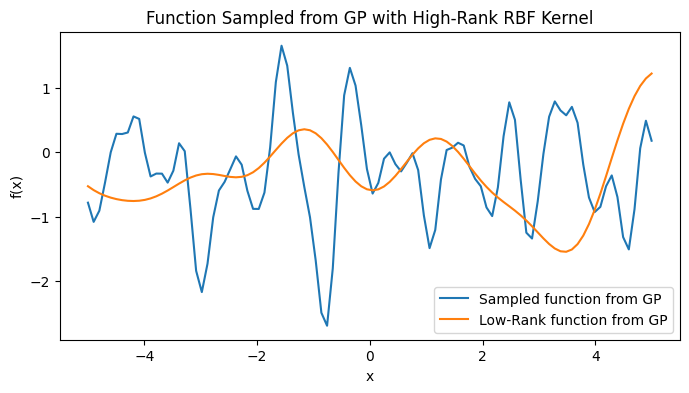

In [4]:
# Generate input points
X = np.linspace(-5, 5, 10**2).reshape(-1, 1)

# Compute kernel matrix (covariance matrix for the GP)
K = rbf_kernel(X, X, length_scale=0.2)
K_low_rank = rbf_kernel(X, X, length_scale=1)

# Sample from a Gaussian Process (mean=0, covariance=K)
f_samples = np.random.multivariate_normal(mean=np.zeros(len(X)), cov=K)
f_samples_low_rank = np.random.multivariate_normal(mean=np.zeros(len(X)), cov=K_low_rank)

# Plot the sampled function
plt.figure(figsize=(8, 4))
plt.plot(X, f_samples, label="Sampled function from GP")
plt.plot(X, f_samples_low_rank, label="Low-Rank function from GP")
plt.title("Function Sampled from GP with High-Rank RBF Kernel")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.show()

In [12]:
class GPfunctions:
    def __init__(self, K, length_scale,actionspace=None):
        self.K=K
        self.num_points= 500 #number of actions
        if len(actionspace)==0:
            actionspace = np.random.choice(np.linspace(-5, 5, 10**5), self.num_points, replace=False).reshape(-1, 1)
        self.actionspace = np.sort(actionspace,axis=0)
        self.length_scale=length_scale
        # Compute covariance matrix
        self.kernel = self.rbf_kernel()
        self.subset = self.algorithm()

    # RBF (Gaussian) Kernel
    def rbf_kernel(self):
        """Computes the RBF kernel matrix."""
        sq_dist = cdist(self.actionspace,self.actionspace, 'sqeuclidean')
        return np.exp(-sq_dist / (2 * self.length_scale ** 2))
    
    def samples(self):
        return np.random.multivariate_normal(mean=np.zeros(self.num_points), cov=self.kernel)

    def algorithm(self):
        # Sample multiple functions from the GP
        f_samples = np.random.multivariate_normal(mean=np.zeros(self.num_points), cov=self.kernel, size=self.K)
        # Find the max index for each batch
        max_indices = np.argmax(f_samples, axis=1)  # Shape: (num_batches,)
        # Get unique max indices
        subset = np.unique(max_indices)
        # print("Unique actions:", subset)
        return subset
    
    def test(self,subset):
        num_batches = 10**5  # Number of function samples for testing
        # Sample multiple functions from the GP
        f_samples = np.random.multivariate_normal(mean=np.zeros(self.num_points), cov=self.kernel, size=num_batches)
        return np.average(np.max(f_samples, axis=1)-np.max(f_samples[:,subset], axis=1))

    def ucb_action_selection(self, N, c=1.0):
        """
        Selects a subset of K actions using Upper Confidence Bound (UCB).
        Returns: List of selected action indices.
        """

        # Initialization
        selected_actions = list(np.random.choice([*range(self.num_points)], self.K, replace=False)) 
        ucb_values = np.zeros(self.num_points)
        freq=np.ones(self.num_points)
        num_batches = N  # Number of function samples for UCB
        # Sample multiple functions from the GP
        f_samples = np.random.multivariate_normal(mean=np.zeros(self.num_points), cov=self.kernel, size=num_batches)
        for t in range(N):
            ucb_values[selected_actions] = f_samples[t,selected_actions] + c * np.sqrt(np.log(t + 1) / freq[selected_actions])  
            selected_actions = np.argsort(ucb_values)[-self.K:]  # Top K actions with highest UCB
            freq[selected_actions]+=freq[selected_actions]
        return selected_actions
    
    def ts_action_selection(self, N):
        """
        Selects a subset of K actions using Thompson Sampling.
        Returns: List of selected action indices.
        """
        num_batches = N  # Number of function samples for UCB
        # Sample multiple functions from the GP
        f_samples = np.random.multivariate_normal(mean=np.zeros(self.num_points), cov=self.kernel, size=num_batches)
        mu = np.full(self.num_points, 0)  # Mean of the prior 0
        var = np.full(self.num_points, 1) # Variance of the prior 1
        noise_var=1e-2

        for t in range(N):
            sampled_means = np.random.multivariate_normal(mu, np.diag(var))
            selected_actions= np.argsort(sampled_means)[-self.K:]
            # 1e-8 for preventing zero division
            new_var = 1 / (1 / (var[selected_actions] + 1e-8) + 1 / noise_var) # Bayesian update for variance 
            new_mu = new_var * (mu[selected_actions] / (var[selected_actions]+ 1e-8) +  f_samples[t,selected_actions] / noise_var)  # Update mean
            # Store updated values
            mu[selected_actions] = new_mu
            var[selected_actions] = new_var

        return selected_actions

    # def ts_action_selection(self, N):
    #     """
    #     Selects a subset of K actions using Thompson Sampling.
        
    #     Returns: List of selected action indices.
    #     """
    #     num_batches = N  # Number of function samples for UCB
    #     # Sample multiple functions from the GP
    #     f_samples = np.random.multivariate_normal(mean=np.zeros(self.num_points), cov=self.kernel, size=num_batches)
    #     mu = np.full(self.num_points, 0)  # Mean of the prior 0
    #     noise_var=1e-2
    #     kernel_ts = self.kernel + noise_var * np.eye(self.num_points) # Variance of the prior 1

    #     for t in range(N):
    #         sampled_means = np.random.multivariate_normal(mu, kernel_ts)
    #         selected_actions= np.argsort(sampled_means)[-self.K:]
    #         mu[selected_actions] = f_samples[t,selected_actions]
    #         kernel_ts[selected_actions,selected_actions] += noise_var  # Update covariance matrix
    #     return selected_actions

In [14]:
cardinality

,Cardinality,length_scale,K
0,5.0,0.1,5.0
1,5.0,0.1,5.0
2,5.0,0.1,5.0
3,4.0,0.5,5.0
4,5.0,0.5,5.0


In [18]:
report=pd.DataFrame(columns=['EmpiricialRegret','length_scale','K','method'])
actionspace = np.random.choice(np.linspace(-5, 5, 10**5), 500, replace=False).reshape(-1, 1)
length_range=[0.1,0.5,1,1.5,2]

cardinality=pd.DataFrame(columns=['Cardinality','length_scale','K'])

for K in [5,10]:
    for length_scale in length_range:
        for ignore in range(10):
            fun=GPfunctions(K,length_scale,actionspace=actionspace)
            card=pd.Series({'Cardinality':len(fun.subset),'length_scale':length_scale,'K':K})
            cardinality = pd.concat([cardinality,card.to_frame().T], ignore_index=True)

            output=fun.test(fun.subset)
            ucb=fun.test(fun.ucb_action_selection(N=3000))
            ts=fun.test(fun.ts_action_selection(N=500))
            row=pd.Series({'EmpiricialRegret':output,'length_scale':length_scale,'K':K,'method':'epsilon'})
            row_ucb=pd.Series({'EmpiricialRegret':ucb,'length_scale':length_scale,'K':K,'method':'ucb'})
            row_ts=pd.Series({'EmpiricialRegret':ts,'length_scale':length_scale,'K':K,'method':'ts'})
            report = pd.concat([report,row.to_frame().T,row_ucb.to_frame().T,row_ts.to_frame().T], ignore_index=True)

report.to_csv('report.csv',index=None)
cardinality.to_csv('cardinality.csv',index=None)

/tmp/ipykernel_6246/1359535877.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cardinality = pd.concat([cardinality,card.to_frame().T], ignore_index=True)


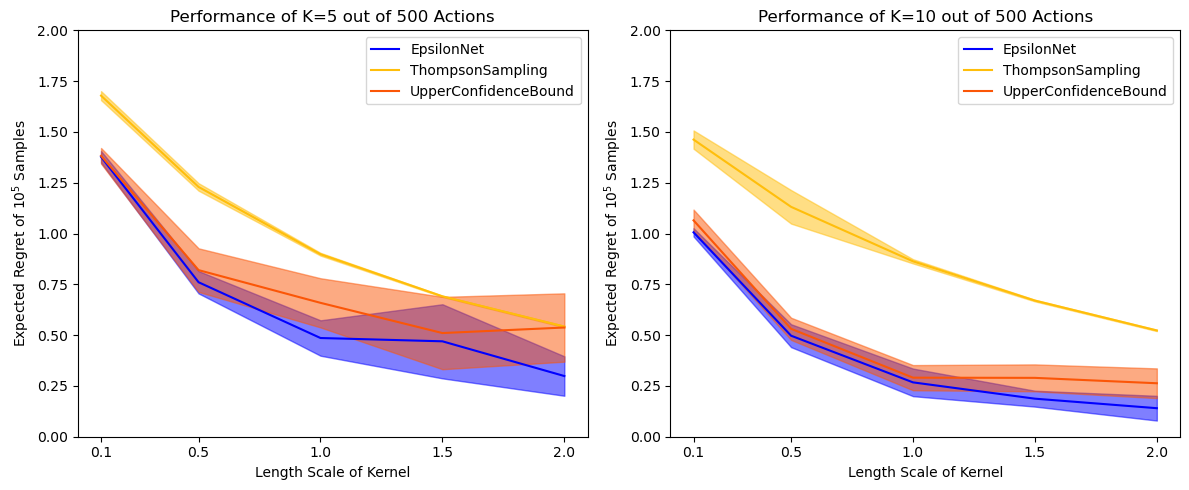

In [19]:
fig, axes = plt.subplots(1,2,figsize=(12, 5))  # (rows, cols)
methods = ['epsilon','ts','ucb']
methodnames = dict(zip(methods,['EpsilonNet','ThompsonSampling','UpperConfidenceBound']))
krange = [5,10]
colormap = dict(zip(methods, ['b','#FFBE0B','#FB5607']))

for i in range(2):
    for m in methods:
        dfmean=report.groupby(by=["length_scale",'K','method']).mean()['EmpiricialRegret']
        mean=np.array([dfmean[l][krange[i]][m] for l in length_range])
        dfstd=report.groupby(by=["length_scale",'K','method']).std()['EmpiricialRegret']
        std=np.array([dfstd[l][krange[i]][m] for l in length_range])
        axes[i].plot(length_range, mean, label="{}".format(methodnames[m]), color=colormap[m])
        axes[i].fill_between(length_range, mean-std, mean+std, color=colormap[m],alpha=0.5)

    axes[i].set_ylim([0,2])
    axes[i].set_title("Performance of K={} out of 500 Actions".format(krange[i]))
    axes[i].set_xlabel("Length Scale of Kernel")
    axes[i].set_xticks(length_range)
    axes[i].set_ylabel(r"Expected Regret of $10^5$ Samples")
    axes[i].legend()

# Save plot as a PDF without margins
plt.savefig("RKHS_baselines.pdf", format="pdf", bbox_inches='tight', pad_inches=0, transparent=True)

# Adjust layout
plt.tight_layout()
plt.show()

In [21]:
report.groupby(by=["length_scale",'K','method']).mean()

EmpiricialRegret
length_scale K  method                  
0.1          5  epsilon         1.370773
                ts              1.870785
                ucb             1.390457
             10 epsilon          1.00962
                ts              1.774077
                ucb             1.043306
0.5          5  epsilon         0.769712
                ts              1.266959
                ucb             0.842248
             10 epsilon         0.497713
                ts               1.24313
                ucb             0.553032
1.0          5  epsilon         0.510599
                ts              0.921359
                ucb             0.661901
             10 epsilon         0.317959
                ts              0.911396
                ucb              0.39207
1.5          5  epsilon         0.418071
                ts              0.707619
                ucb             0.484225
             10 epsilon         0.137814
                ts              0.700081
                ucb             0.259653
2.0          5  epsilon          0.36544
                ts               0.55503
                ucb             0.366407
             10 epsilon         0.129766
                ts              0.548525
                ucb             0.221183
2.5          5  epsilon         0.154756
                ts              0.437123
                ucb             0.329777
             10 epsilon         0.093355
                ts              0.431705
                ucb             0.243134

TypeError: agg function failed [how->mean,dtype->object]

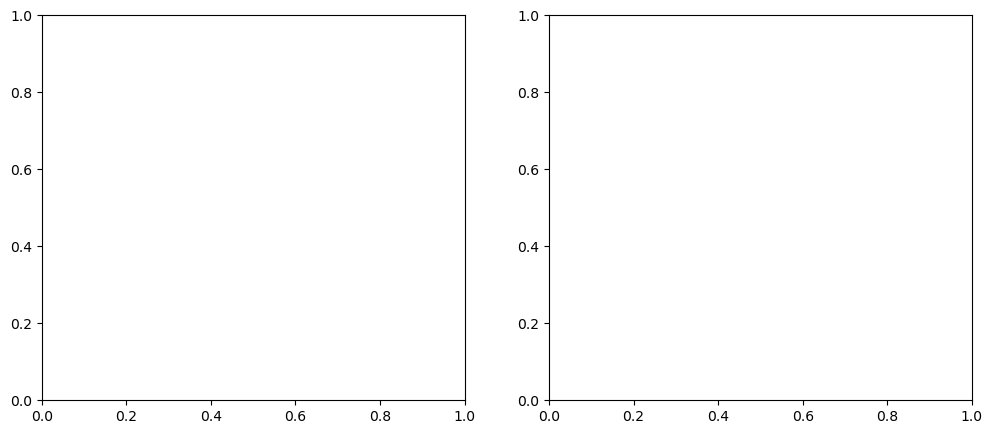

In [10]:
fig, axes = plt.subplots(1,2,figsize=(12, 5))  # (rows, cols)

colormap = dict(zip([5,10]+length_range, ['c','b']+['#DC97FF','#BD68EE','#8B2FC9','#5a108f','#4A0A77','#310055']))

i=0
for K in [5,10]:
    dfmean=report.groupby(by=["length_scale",'K']).mean()['EmpiricialRegret']
    mean=np.array([dfmean[i][K] for i in length_range])
    dfstd=report.groupby(by=["length_scale",'K']).std()['EmpiricialRegret']
    std=np.array([dfstd[i][K] for i in length_range])
    axes[i].plot(length_range, mean, label="K={}".format(K), color=colormap[K])
    axes[i].fill_between(length_range, mean-std, mean+std, color=colormap[K],alpha=0.5)

# axes[i].set_ylim([0,1.5])
axes[i].set_title("Performance of K out of 500 Actions")
axes[i].set_xlabel("Length Scale of Kernel")
axes[i].set_xticks(length_range)
axes[i].set_ylabel(r"Empirical Expected Regret of $10^4$ Samples")
axes[i].legend()

i=1
for l in length_range:
    fun=GPfunctions(1,l,actionspace=actionspace)
    axes[i].plot(fun.actionspace,fun.samples(),label="{:.1f}".format(l), color=colormap[l])

axes[i].set_title("Examples of Sampled Functions")
axes[i].set_xlabel("Full Action Space with Cardinality 500")
axes[i].set_xticks([])
axes[i].set_ylabel(r"Expected Outcome of Actions")
axes[i].legend(title='Length Scale of Kernel',ncol=2)

# Save plot as a PDF without margins
# plt.savefig("RKHS.pdf", format="pdf", bbox_inches='tight', pad_inches=0, transparent=True)

# Adjust layout
plt.tight_layout()
plt.show()

In [337]:
def thompson_sampling_action_selection(alpha, beta, K=5):
    """
    Selects a subset of K actions using Thompson Sampling.
    
    alpha, beta: Parameters of the Beta distribution for each action.
    K: Number of actions to select.
    
    Returns: List of selected action indices.
    """
    sampled_values = np.random.beta(alpha, beta)  # Sample from Beta distribution
    selected_actions = np.argsort(sampled_values)[-K:]  # Select top K actions
    return selected_actions

# Example usage
num_actions = 10
alpha = np.ones(num_actions)  # Prior successes (initialize as 1)
beta = np.ones(num_actions)   # Prior failures (initialize as 1)
selected_actions = thompson_sampling_action_selection(alpha, beta, K=5)

print("Selected actions using Thompson Sampling:", selected_actions)

Selected actions using Thompson Sampling: [2 5 6 0 7]


In [338]:
def ucb_action_selection(Q, N, t, c=1.0, K=5):
    """
    Selects a subset of K actions using Upper Confidence Bound (UCB).
    
    Q: Estimated rewards for each action.
    N: Number of times each action has been selected.
    t: Current time step.
    c: Exploration-exploitation trade-off parameter.
    K: Number of actions to select.
    
    Returns: List of selected action indices.
    """
    ucb_values = Q + c * np.sqrt(np.log(t + 1) / (N + 1e-5))  # Avoid division by zero
    selected_actions = np.argsort(ucb_values)[-K:]  # Top K actions with highest UCB
    return selected_actions

# Example usage
num_actions = 10
Q = np.random.rand(num_actions)  # Random estimated rewards
N = np.ones(num_actions)  # Initialize with 1 to avoid division by zero
t = 100  # Current time step
selected_actions = ucb_action_selection(Q, N, t, K=5)

print("Selected actions using UCB:", selected_actions)


Selected actions using UCB: [2 8 9 0 1]


In [194]:


dfmean=report.groupby(by=["length_scale",'K']).mean()['EmpiricialRegret']
mean=np.array([dfmean[i][5.0] for i in [0.1,0.2,0.5,1.,1.5,2]])
dfstd=report.groupby(by=["length_scale",'K']).std()['EmpiricialRegret']
std=np.array([dfstd[i][5.0] for i in [0.1,0.2,0.5,1.,1.5,2]])



In [277]:
report.groupby(by=["length_scale",'K']).mean()

EmpiricialRegret
length_scale K                     
0.1          5.0           0.968969
             10.0          0.658666
0.2          5.0           0.969845
             10.0          0.612436
0.5          5.0           0.664523
             10.0          0.370710
1.0          5.0           0.515914
             10.0          0.279531
1.5          5.0           0.404753
             10.0          0.112570
2.0          5.0           0.258277
             10.0          0.106087

In [278]:
report.groupby(by=["length_scale",'K']).std()

EmpiricialRegret
length_scale K                     
0.1          5.0           0.008003
             10.0          0.031927
0.2          5.0           0.055027
             10.0          0.108203
0.5          5.0           0.080587
             10.0          0.053958
1.0          5.0           0.117663
             10.0          0.056348
1.5          5.0           0.069309
             10.0          0.059978
2.0          5.0           0.086438
             10.0          0.048114